In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.hops import hops
from src.util import noise_generator

In [10]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [11]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [1, 2, 4, 8, 1000]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta)
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)

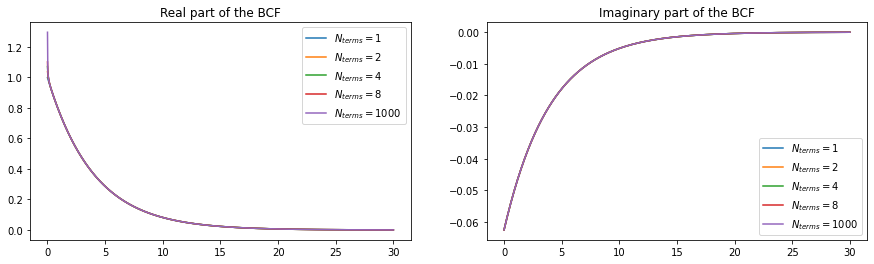

In [12]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].legend()
axarray[0].set_title("Real part of the BCF")
axarray[1].legend()
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

The BCF is sufficiently converged already at $N_\text{terms} = 1$! 

In [13]:
N_terms = 1

In [58]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
N_terms_memory = 100000
g_memory, w_memory = debye_spectral_density.get_debye_coefficients(N_terms_memory, T, gamma, eta)

# Simple non-noise runs: HOPS (RK4), HOMPS (RK4), HOMPS (TDVP)

### HOPS (RK4)

In [19]:
N_steps = 1000
N_trunc = 100
options = {
    'linear' : False,
    'use_noise' : False,
}

In [20]:
print("Computing N_steps =", N_steps)
start = time.time()
options['linear'] = True
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
psis_linear = my_hops.compute_realizations(1)
options['linear'] = False
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
psis_nonlinear = my_hops.compute_realizations(1)
end = time.time()
print("took", end-start, "seconds.")

Computing N_steps = 1000
took 0.7574062347412109 seconds.


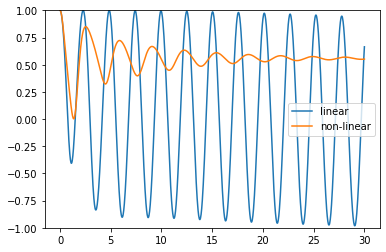

In [21]:
sigma_zs_linear = compute_exp_val_linear(psis_linear, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_linear, label="linear")
sigma_zs_nonlinear = compute_exp_val_nonlinear(psis_nonlinear, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_nonlinear, label="non-linear")
plt.ylim(-1., 1.)
plt.legend()
plt.show()

### HOMPS (RK4)

In [23]:
N_steps = 500
N_trunc = 40
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'optimize_mpo' : False,
}

In [24]:
print("Computing N_steps =", N_steps)
start = time.time()
options['linear'] = True
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_linear = my_homps.compute_realizations(1)
options['linear'] = False
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_nonlinear = my_homps.compute_realizations(1)
end = time.time()
print("took", end-start, "seconds.")

Computing N_steps = 500
took 1.3866503238677979 seconds.


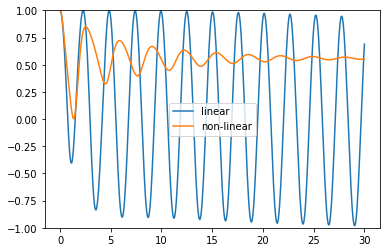

In [25]:
sigma_zs_linear = compute_exp_val_linear(psis_linear, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_linear, label="linear")
sigma_zs_nonlinear = compute_exp_val_nonlinear(psis_nonlinear, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_nonlinear, label="non-linear")
plt.ylim(-1., 1.)
plt.legend()
plt.show()

### HOMPS (TDVP2)

In [26]:
N_steps = 500
N_trunc = 25
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'TDVP2',
}

In [27]:
print("Computing N_steps =", N_steps)
start = time.time()
options['linear'] = True
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_linear = my_homps.compute_realizations(1)
options['linear'] = False
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_nonlinear = my_homps.compute_realizations(1)
end = time.time()
print("took", end-start, "seconds.")

Computing N_steps = 500
took 1.976179838180542 seconds.


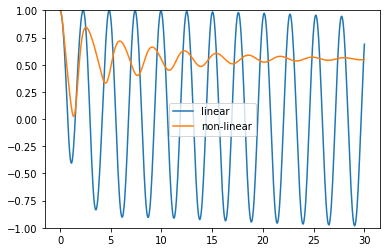

In [28]:
sigma_zs_linear = compute_exp_val_linear(psis_linear, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_linear, label="linear")
sigma_zs_nonlinear = compute_exp_val_nonlinear(psis_nonlinear, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_nonlinear, label="non-linear")
plt.ylim(-1., 1.)
plt.legend()
plt.show()

# HOMPS (RK4): Convergence in N_steps (without noise)

In [31]:
N_steps_list = [100, 250, 500, 1000, 10000]
N_trunc = 40

In [32]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
}

In [33]:
psis_N_steps = []

for N_steps in N_steps_list:
    print("Computing N_steps =", N_steps)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_steps.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_steps = 100
took 0.18658804893493652 seconds.
Computing N_steps = 250
took 0.40845751762390137 seconds.
Computing N_steps = 500
took 0.7911853790283203 seconds.
Computing N_steps = 1000
took 1.5489041805267334 seconds.
Computing N_steps = 10000
took 15.648411989212036 seconds.


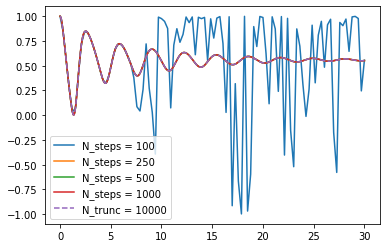

In [34]:
for i, N_steps in enumerate(N_steps_list[:-1]):
    sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_steps = "+str(N_steps))
sigma_zs = compute_exp_val_nonlinear(psis_N_steps[-1], sigma_z)
plt.plot(np.linspace(0, duration, N_steps_list[-1]), sigma_zs, "--", label="N_trunc = "+str(N_steps_list[-1]))
plt.legend()
plt.show()

# HOMPS (RK4): Convergence in N_trunc (without noise)

In [43]:
N_steps = 500
N_trunc_list = [5, 10, 15, 20, 25, 30, 35, 40]

In [47]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
}

In [48]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 5
took 0.7142131328582764 seconds.
Computing N_trunc = 10
took 0.7257378101348877 seconds.
Computing N_trunc = 15
took 0.7251801490783691 seconds.
Computing N_trunc = 20
took 0.7234189510345459 seconds.
Computing N_trunc = 25
took 0.7772068977355957 seconds.
Computing N_trunc = 30
took 0.7997012138366699 seconds.
Computing N_trunc = 35
took 0.8696012496948242 seconds.
Computing N_trunc = 40
took 0.8548061847686768 seconds.


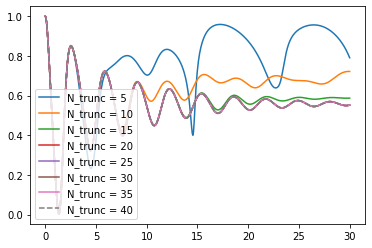

In [50]:
for i, N_trunc in enumerate(N_trunc_list[:-1]):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[-1], sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "--", label="N_trunc = "+str(N_trunc_list[-1]))
plt.legend()
plt.show()

# HOMPS (RK4): Convergence in N_trunc (with noise)

In [51]:
N_steps = 500
N_trunc_list = [10, 15, 20, 25, 30, 35, 40]

In [54]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
}
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc_list[0], options)
zts_debug = my_homps.generator.sample_process()

In [55]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1, zts_debug=zts_debug))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 10
took 0.6720290184020996 seconds.
Computing N_trunc = 15
took 0.6544885635375977 seconds.
Computing N_trunc = 20
took 0.695824146270752 seconds.
Computing N_trunc = 25
took 0.7491538524627686 seconds.
Computing N_trunc = 30
took 0.7407469749450684 seconds.
Computing N_trunc = 35
took 0.8041999340057373 seconds.
Computing N_trunc = 40
took 0.7982242107391357 seconds.


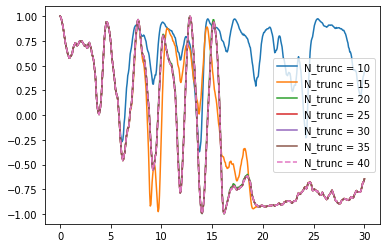

In [56]:
for i, N_trunc in enumerate(N_trunc_list[:-1]):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[-1], sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "--", label="N_trunc = "+str(N_trunc_list[-1]))
plt.legend()
plt.show()

# Using more memory terms

## without noise

In [65]:
N_steps = 500
N_trunc = 40
N_terms_memory_list = [1, 2, 3, 4]
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'optimize_mpo' : False,
    'g_memory' : g_memory,
    'w_memory' : w_memory,
}

In [66]:
psis_N_terms_memory = []

for i, N_terms_memory in enumerate(N_terms_memory_list):
    print("Computing N_terms_memory =", N_terms_memory)
    start = time.time()
    options['g_memory'] = g_memory[:N_terms_memory]
    options['w_memory'] = w_memory[:N_terms_memory]
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_terms_memory.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_terms_memory = 1
took 0.78731369972229 seconds.
Computing N_terms_memory = 2
took 0.8227987289428711 seconds.
Computing N_terms_memory = 3
took 0.812227725982666 seconds.
Computing N_terms_memory = 4
took 0.8078532218933105 seconds.


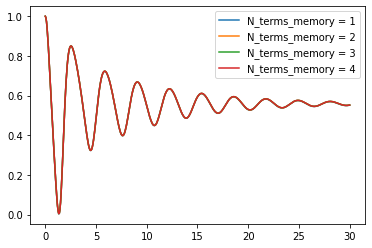

In [67]:
for i, N_terms_memory in enumerate(N_terms_memory_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_terms_memory[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms_memory = "+str(N_terms_memory))
plt.legend()
plt.show()

## with noise

In [70]:
N_steps = 500
N_trunc = 40
N_terms_memory_list = [1, 2, 3, 4]
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'optimize_mpo' : False,
    'g_memory' : g_memory,
    'w_memory' : w_memory,
}
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [71]:
psis_N_terms_memory = []

for i, N_terms_memory in enumerate(N_terms_memory_list):
    print("Computing N_terms_memory =", N_terms_memory)
    start = time.time()
    options['g_memory'] = g_memory[:N_terms_memory]
    options['w_memory'] = w_memory[:N_terms_memory]
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_terms_memory.append(my_homps.compute_realizations(1, zts_debug=zts_debug))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_terms_memory = 1
took 0.8151710033416748 seconds.
Computing N_terms_memory = 2
took 0.8217194080352783 seconds.
Computing N_terms_memory = 3
took 0.7924239635467529 seconds.
Computing N_terms_memory = 4
took 0.8257501125335693 seconds.


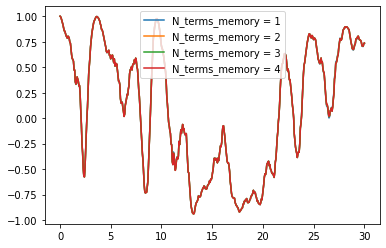

In [72]:
for i, N_terms_memory in enumerate(N_terms_memory_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_terms_memory[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms_memory = "+str(N_terms_memory))
plt.legend()
plt.show()

# HOMPS (RK4): Full Run

In [73]:
N_steps = 500
N_trunc = 40

In [76]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
}

In [77]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [78]:
psis_100 = my_homps.compute_realizations(100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [79]:
psis_1000 = my_homps.compute_realizations(1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
psis_10000 = my_homps.compute_realizations(10000, progressBar=tqdm)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [87]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
sigma_zs_1000 = compute_exp_val_nonlinear(psis_1000, sigma_z)
sigma_zs_10000 = compute_exp_val_nonlinear(psis_10000, sigma_z)

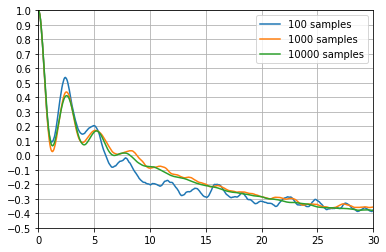

In [88]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_10000, label="10000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.yticks(np.linspace(-0.5, 1, 16))
plt.grid()
plt.show()

In [96]:
for i in range(100):
    np.save("../../production/homps_high_T_100/data/psi"+str(i), psis_100[i, :, :])